# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [5]:
# Загрузим датасет - содержит 50 тысяч отзывов с сайта imdb
dataset = datasets.load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation)) # убираем пунктуацию, приводим к нижнему регистру

    for word in word_tokenize(prccessed_text): # находим все слова в конкретном предложении и считаем частоту вхождений
        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25 # задаем так, чтобы попали слова, встречающиеся более 25 раз

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [9]:
len(vocab)

11399

In [11]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

# проиндексируем слова в словаре

In [13]:
class WordDataset: # Датасет в котором мы будем хранить наши примерыи и далее подавать в torch DataLoader
    def __init__(self, sentences): # 1) Конструктор
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]: # имплементируем getitem, чтобы по индексу могли получать конкретный пример из нашего датасета
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation)) # приводим к нижнему регистру, удаляем пунктуацию
        tokenized_sentence = [self.bos_id] # id служебного токена в начало строки BEGGIN OF SENTENCE
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] # после для каждого слова в предложении пытаемся достать id слова из нашего словаря, если не получается, то возвращаем id UNK токена
        tokenized_sentence += [self.eos_id] # id служебного токена в конец строки END OF SENTENCE

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        } # собираем в словарь

        return train_sample

    def __len__(self) -> int: # имплементируем len, чтобы dataloader мог понимать на сколько большой у нас датасет
        return len(self.data)

In [14]:
## Необходима для того, чтобы собирать последовательности разной длины в один батч.
### Она получает на вход входной батч (список объектов, полученных из getitem), ограничиваем длину макс последовательности
### и делаем паддинг для тех последовательностей, которые не дотягивают до максимальной длины

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text']) # после того как батч сформировался с последовательностями одиннаковой длины передаем в тензор

    sequences = torch.LongTensor(new_batch).to(device) # полученный батч переводим в тензон и кладем на нужный девайс
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device) # тоже самое делаем с метками классов

    new_batch = {
        'input_ids': sequences,
        'label': labels
    } # собираем в словарь, где ключ input_ids это индекс тензора токенов, а по ключу label - метка класса

    return new_batch

In [15]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx)) # для валидации возьмем всего 2000 примеров

batch_size = 128 # размер батча на котором происходят вычисления
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Архитектура модели

In [20]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim] ! Получаем батч и считаем эмбеддинги
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] ! После используем RNN блок

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim] ! MAX Pooling агрегация
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim] ! AVERAGE Pooling агрегация
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim] ! Проганяем наши представления через полносвязную сеть: сначала активация, потом линейная функция, потом дропаут
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes] ! После дропаута снова активация и в конце предсказание

        return prediction

## Train loop

In [21]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad(): # На валидации мы градиенты не считаем
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions) # конкатинация всех предсказаний из батчей
    target = torch.cat(target) # конкатинация всех таргетов из батчей
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [18]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device) # Наша модель, которую положили на ГПУ
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']) # CE лосс критерий с игнором pad'а
optimizer = torch.optim.Adam(model.parameters()) # Оптимизатор Адам с параметрами модели и дефолтным LR

In [19]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad() # обнуляем градиенты
            logits = model(batch['input_ids']) # считаем логиты (forward pass)
            loss = criterion(logits, batch['label']) # считаем loss
            loss.backward() # считаем градиенты backprop
            optimizer.step() # шаг градиентного спуска

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval() # eval необходим для отключения dropout'а
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

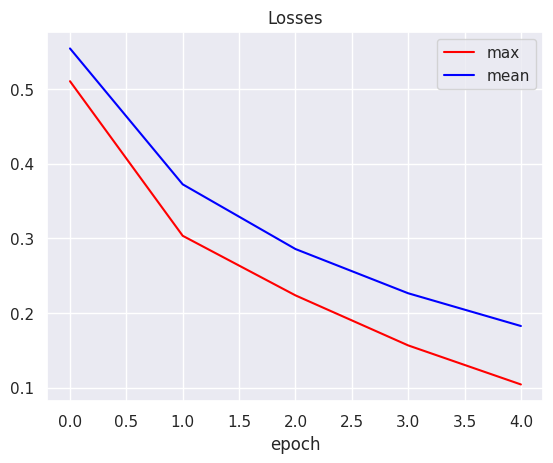

In [22]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 86.55
Лучшая accuracy для подхода mean: 86.55


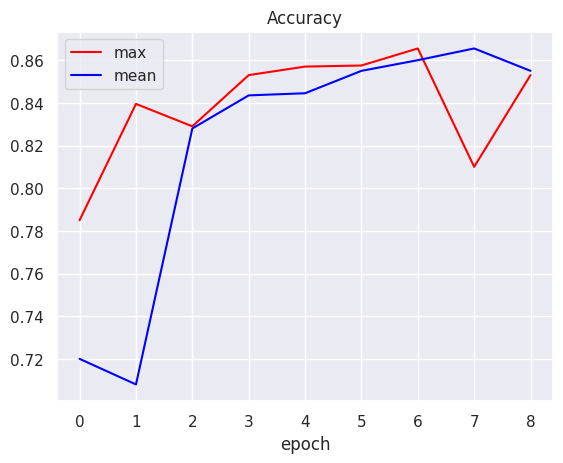

In [23]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [24]:
# В конце тренировки агрегация average выйграла!